![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics


# Advection Diffusion in 2D -- TH coupled heat transport problem

In [124]:
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm

#Some plot settings
%run plot_functions/plot_settings.py

In [125]:
#element class
class quad4_element():#local coordinates go from -1 to 1
    #takes global nodal coordinates, global node ids
    def __init__(self, ncoords=[[0.,0.],[1.,0.],[1.,1.],[0.,1.]], nids=[0,1,2,3]):
        self.__nnodes = 4
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = np.array([[-1.,-1.],[1.,-1.],[1.,1.],[-1.,1.]])
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = 2
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
    
    def get_centroid(self):
        return [np.mean(self.__coords[:,0]),np.mean(self.__coords[:,1])]

In [126]:
#Q4 elements
def generate_discrete_domain(dx=10,dy=10,nelx=6,nely=6): 
    nnx = nelx+1
    nny = nely+1
    node_list = np.array([[0.0,0.0]]*(nnx)*(nny))
    c = 0
    for i in range(nnx):
        for j in range(nny):
            node_list[c][0] = (i/nelx)*dx
            node_list[c][1] = (j/nely)*dy
            c += 1


    connectivity = [[]]
    for i in range(nelx):
        for j in range(nely):
            connectivity.append([j+i*nny,j+(i+1)*nny,j+(i+1)*nny+1,j+i*nny+1]) #j+i*nx,j+i*nx+3,j+i*nx+4,j+i*nx+1

    connectivity.remove([])

    element_vector = []
    for i in range(len(connectivity)):
        element_vector.append(quad4_element([node_list[connectivity[i][0]],
                                             node_list[connectivity[i][1]],
                                             node_list[connectivity[i][2]],
                                             node_list[connectivity[i][3]]],
                                            connectivity[i]))
    solution = np.array([0.]*len(node_list))
    return connectivity, element_vector, node_list, solution

In [127]:
def plot_mesh(node_list,element_vector):
    fig, ax = plt.subplots(figsize=(12,12))
    for i,n in enumerate(node_list):
        ax.plot(n[0],n[1],color='black',marker='o')
        ax.text(n[0]+dx/150,n[1]+dy/150,'%i' %i)
    for ne,e in enumerate(element_vector):
        e_coords = e._quad4_element__coords
        for i in range(len(e_coords)):
            ax.plot([e_coords[i-1,0],e_coords[i,0]],[e_coords[i-1,1],e_coords[i,1]],color='blue')
        ax.text(e.get_centroid()[0],e.get_centroid()[1],'%i' %ne, color='blue')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal')
    fig.tight_layout();

In [128]:
#N
def shape_function(xi,eta):
    return np.array([(1-xi)*(1-eta),
                     (1+xi)*(1-eta),
                     (1+xi)*(1+eta),
                     (1-xi)*(1+eta)])/4.
#dN_dxi
def dshape_function_dxi(xi,eta):
    return np.array([[-(1-eta), -(1-xi)],
                     [+(1-eta), -(1+xi)],
                     [+(1+eta), +(1+xi)],
                     [-(1+eta), +(1-xi)]]).T/4.

    
#untested
def element_jacobian(xi,eta,element):
    Jacobian = np.dot(dshape_function_dxi(xi,eta),element._quad4_element__coords)
    #Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#untested
def grad_shape_function(xi,eta,element):
    Jac = element_jacobian(xi,eta,element)
    return np.dot(dshape_function_dxi(xi,eta).T,np.linalg.inv(Jac)).T

In [129]:
def test_gradN(xi,eta):
    dNdX = dshape_function_dxi(xi,eta)
    dNdX_num1 = (shape_function(xi+1e-8,eta) - shape_function(xi-1e-8,eta))/2e-8
    dNdX_num2 = (shape_function(xi,eta+1e-8) - shape_function(xi,eta-1e-8))/2e-8
    dNdX_num = np.array([dNdX_num1,dNdX_num2]).T
    return np.max(dNdX_num-dNdX)

## Potential flow

PDE:

$$
    0 = q_{i,i} \quad \text{with} \quad q_i = - \frac{k_{ij}}{\mu} p_{,j}
$$

so that

$$
    0 = \left(\frac{k_{ij}}{\mu} p_{,j}\right)_{,i}
$$

Weak form:

\begin{align}
    0 &= \int \limits_\Omega v q_{i,i} \,\text{d}\Omega = \int \limits_{\partial \Omega_q} v q_\text{out} \,\text{d}\Gamma - \int \limits_\Omega v_{,i} q_i \,\text{d}\Omega
    \\
    0 &= \int \limits_\Omega v_{,i} \frac{k_{ij}}{\mu} p_{,j} \,\text{d}\Omega - \int \limits_{\partial \Omega_q} v q_\text{in} \,\text{d}\Gamma
\end{align}

Discretized form ($k$ equations):

$$
    0 = \int \limits_\Omega \nabla N_{ik} \frac{k_{ij}}{\mu} \nabla N_{jl} \,\text{d}\Omega\ \hat{p}_l - \int \limits_{\partial \Omega_q} N_k q_\text{in} \,\text{d}\Gamma
$$

and elementwise:

$$
    0 = \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_\Omega \nabla N_{ik} \frac{k_{ij}}{\mu} \nabla N_{jl}\,\det J \,\text{d}\Omega_e\ \hat{p}_l - \bigcup \limits_{e=1}^{n_\text{el}^q} \int \limits_{\partial \Omega_{e,q}} N_k q_\text{in} \det J_\Gamma \,\text{d}\Gamma_e
$$

## Heat transport

Now we use the computed flow simulation as input for a heat transport simulation, considering a one-sided H$\rightarrow$T problem:

$$
    0 = (\varrho c_p)^\text{eff} \dot{T} - (\lambda^\text{eff}_{ij} T_{,j})_{,i} + \varrho^\text{w} c_p^\text{w} q_i T_{,i}
$$

This form leads to a Neumann bc for the conductive heat flux:

$$
\begin{align}
    -\int \limits_\Omega v (\lambda^\text{eff}_{ij} T_{,j})_{,i} \text{d}\Omega &= \int \limits_\Omega v q^T_{i,i} \text{d}\Omega = -\int \limits_{\partial \Omega_q^T} v q^T_\text{in} \text{d}\Gamma + \int \limits_\Omega v_{,i} \lambda^\text{eff}_{ij} T_{,j} \text{d}\Omega
    \\
    &\text{with } q^T_\text{in} = - q^T_i n_i
\end{align}
$$

Note in passing that the alternative formulation

$$
    0 = (\varrho c_p)^\text{eff} \dot{T} - (\lambda^\text{eff}_{ij} T_{,j})_{,i} + (\varrho^\text{w} c_p^\text{w} q_i T)_{,i}
$$

leads to a Neumann bc for the total heat flux:

$$
\begin{align}
    \int \limits_\Omega v (\varrho^\text{w} c_p^\text{w} q_i T - \lambda^\text{eff}_{ij} T_{,j})_{,i} \text{d}\Omega &= \int \limits_\Omega v (\varrho^\text{w} c_p^\text{w} T q_i + q^T_i)_{,i} \text{d}\Omega = -\int \limits_{\partial \Omega_q^T} v (\varrho^\text{w} c_p^\text{w} T q_\text{in} + q^T_\text{in}) \text{d}\Gamma + \int \limits_\Omega v_{,i} \lambda^\text{eff}_{ij} T_{,j} \text{d}\Omega -  \int \limits_\Omega v_{,i} \varrho^\text{w} c_p^\text{w} q_i T \text{d}\Omega
\end{align}
$$

where $q_\text{in}$ is either specified or calculated at the boundary of the domain. Here, the first approach is chosen.

The weak form is then given as

$$
\begin{align}
    0 &= \int \limits_\Omega v (\varrho c_p)^\text{eff} \dot{T} \text{d}\Omega + \int \limits_\Omega v_{,i} \lambda^\text{eff}_{ij} T_{,j} \text{d}\Omega + \int \limits_\Omega v \varrho^\text{w} c_p^\text{w} q_i T_{,i} \text{d}\Omega - \int \limits_{\partial \Omega_q^T} v q^T_\text{in} \text{d}\Gamma
\end{align}
$$

The discretized version ($k$ equations) reads

$$
\begin{align}
    0 &= \int \limits_\Omega N_k (\varrho c_p)^\text{eff} N_l \text{d}\Omega\ \frac{\hat{T}_l^{n+1} - \hat{T}^n_l}{\Delta t} + \int \limits_\Omega \nabla N_{ik} \lambda^\text{eff}_{ij} \nabla N_{jl} \text{d}\Omega\ \hat{T}_l^{n+1} + \int \limits_\Omega N_k \varrho^\text{w} c_p^\text{w} q_i \nabla N_{il} \text{d}\Omega\ \hat{T}_l^{n+1} - \int \limits_{\partial \Omega_q^T} N_k q^T_\text{in} \text{d}\Gamma
\end{align}
$$

## Local assembers

For now without Neumann boundaries. We create one assembler for the H problem, one for the T problem.

In [130]:
def local_assembler_H(elem):
    K_loc = np.zeros((4,4))
    nip = elem._quad4_element__quad_degree
    for i in range(nip):
        for j in range(nip):
            #local integration point coordinate
            xi = elem._quad4_element__quad_points[i]
            eta = elem._quad4_element__quad_points[j]
            #shape function
            dN_dX = grad_shape_function(xi,eta,elem)
            #determinant of Jacobian
            detJ = np.linalg.det(element_jacobian(xi,eta,elem))
            #integration weight
            w_i = elem._quad4_element__quad_weights[i]
            w_j = elem._quad4_element__quad_weights[j]
            #assembly of local stiffness matrix
            K_loc += np.dot((dN_dX.T).dot(k/mu),dN_dX) * w_i * w_j * detJ
    return K_loc

In [131]:
def local_assembler_T(elem,dt,T_sol_prev,p_sol):
    K_loc = np.zeros((4,4))
    b_loc = np.zeros(4)
    nip = elem._quad4_element__quad_degree
    for i in range(nip):
        for j in range(nip):
            #local integration point coordinate
            xi = elem._quad4_element__quad_points[i]
            eta = elem._quad4_element__quad_points[j]
            #shape function
            N = shape_function(xi,eta)
            dN_dX = grad_shape_function(xi,eta,elem)
            #determinant of Jacobian
            detJ = np.linalg.det(element_jacobian(xi,eta,elem))
            #integration weight
            w_i = elem._quad4_element__quad_weights[i]
            w_j = elem._quad4_element__quad_weights[j]
            #Darcy velocity in IP
            q = np.dot(-k/mu,dN_dX.dot(p_sol))
            #assembly of local stiffness matrix
            K_loc += (np.dot((dN_dX.T).dot(lambda_eff),dN_dX) + np.outer(N,np.dot(q*rho_w*cp_w,dN_dX)) + 
                np.outer(N,N)*Cvol/dt) * w_i * w_j * detJ
            #K_loc += (np.dot((dN_dX.T).dot(lambda_eff),dN_dX) + np.outer(np.dot(dN_dX.T,q*rho_w*cp_w),N) + 
            #    np.outer(N,N)*Cvol/dt) * w_i * w_j * detJ # in this case special inlet/outlet boundary treatment needed. 
            #assembly of local RHS      
            T_prev = np.dot(N,T_sol_prev)
            b_loc += N * Cvol*T_prev/dt * w_i * w_j * detJ
    return K_loc,b_loc

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [132]:
def global_assembler(nodes,elements,problem='H',dt=0,solution=None,solution2=None):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        if problem == 'H':
            K_i = local_assembler_H(elem)
        else:
            local_solution = np.take(solution,elem._quad4_element__global_ids)
            local_solution2 = np.take(solution2,elem._quad4_element__global_ids)            
            K_i, b_i = local_assembler_T(elem,dt,local_solution,local_solution2)
        for n in range(4):
            if problem == 'T':
                b_glob[elem._quad4_element__global_ids[n]] += b_i[n]
            for n2 in range(4):
                K_glob[elem._quad4_element__global_ids[n],elem._quad4_element__global_ids[n2]] += K_i[n,n2]
    return K_glob, b_glob

## Application of boundary conditions

In [133]:
def apply_Dirichlet_bc(K_glob,b_glob,node_id,value):
    K_glob[node_id,:] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = value
    return K_glob, b_glob

## Problem solution

We now perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

## Solution of the hydraulic problem

In [134]:
k = np.diag([1e-10,1e-10])
mu = 1e-3

phi = 0.3
rho_s = 2700.
rho_w = 1000.
cp_s = 800.
cp_w = 4180.
Cvol = (1-phi)*rho_s*cp_s + phi * rho_w * cp_w
lambda_eff = np.diag([0.8,0.8])

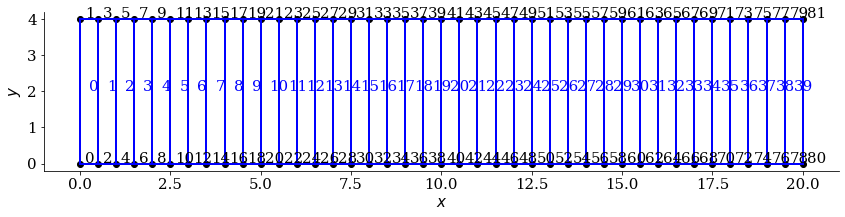

In [135]:
dx = 20
dy = 4
elx = 40
ely = 1
connectivity, element_vector, node_list, solution = generate_discrete_domain(dx=dx,dy=dy,nelx=elx,nely=ely)
plot_mesh(node_list,element_vector)

In [136]:
Kp, fp = global_assembler(node_list,element_vector)
inlet = np.where(node_list.T[0]==0)
outlet = np.where(node_list.T[0]==dx)

pin = 1 #flow problem is linear. solution to be scaled.
pout = 0
for i in inlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, pin)
for i in outlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, 0)

solution_p = np.linalg.solve(Kp,fp)

In [137]:
#solution_p = np.linalg.solve(Kp,fp)
#Kp, fp = global_assembler(node_list,element_vector)
fluxes_p = Kp.dot(solution_p)

In [138]:
def plot_result(node_list,element_vector,solution,fluxes):
    fig, ax = plt.subplots(ncols=2,figsize=(18,7))
    ax[0].tricontourf(node_list[:, 0], node_list[:, 1], solution,alpha=0.4)
    ax[0].scatter(node_list[:, 0], node_list[:, 1], c=solution)
    ax[1].scatter(node_list[:, 0], node_list[:, 1], c=fluxes)
    for figs in range(2):
        ax[figs].set_xlabel('$x$')
        ax[figs].set_ylabel('$y$')
        ax[figs].set_aspect('equal')
    fig.suptitle('pressure (left) and nodal flow rates (right)')
    fig.tight_layout()
    #fig.savefig('pressures_and_fluxes.pdf')
    #fig.savefig('pressures_and_fluxes.png')

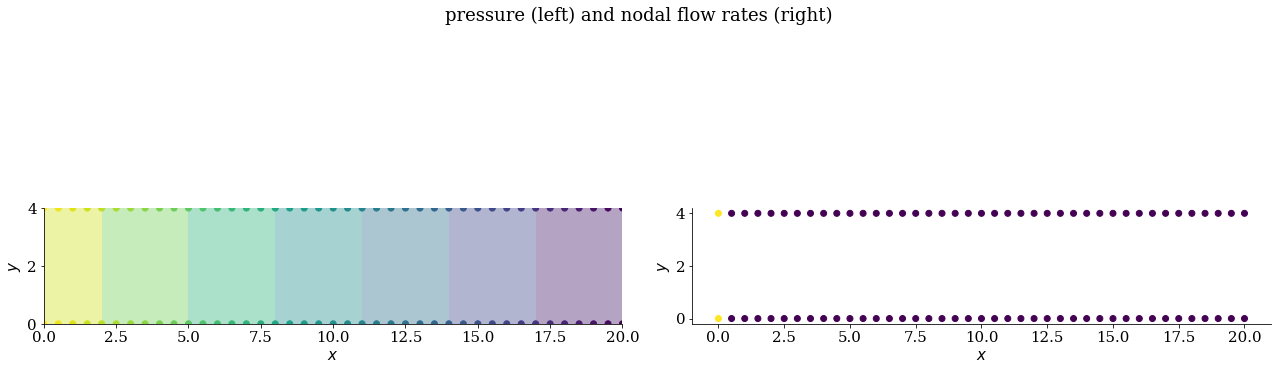

In [139]:
plot_result(node_list,element_vector,solution_p,fluxes_p)

## Solution of the thermal problem

In [140]:
def time_loop(dt,nodes,elements,solution1,solution2,tendfac=1):
    #Startwerte
    t_end = .4*365*60*60*24*tendfac #s
    absolute_tolerance = 1.e-6
    max_iter = 20
    y = [solution1] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = y[-1] #Starting value for recursive update
        i = 0
        #
        while True:
            KT, fT = global_assembler(nodes,elements,'T',dt,y[-1],solution2)
            left = np.where(node_list.T[0]==0)
            for bc in inlet:
                KT, fT = apply_Dirichlet_bc(KT, fT, bc, 10)
            #for bc in right:
            #    KT, fT = apply_Dirichlet_bc(KT, fT, bc, 0.)
            solution = np.linalg.solve(KT,fT)
            i += 1
            if (np.abs(np.linalg.norm(solution) - np.linalg.norm(y_old)) < absolute_tolerance or i > max_iter): #if change is below tolerance, stop iterations
                break
            y_old = solution #preparation of next recursion

        #print(solution)
        y.append(solution) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

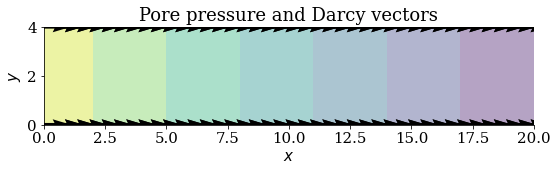

In [141]:
fig, ax = plt.subplots()
ax.tricontourf(node_list[:, 0], node_list[:, 1], solution_p,alpha=0.4)
for i,elem in enumerate(element_vector):
    local_p = np.take(solution_p,elem._quad4_element__global_ids)
    local_coord = elem._quad4_element__natural_coords
    X, Y = np.meshgrid(elem._quad4_element__coords.T[0],elem._quad4_element__coords.T[1])
    for i in range(4):
        dN_dX = grad_shape_function(local_coord[i][0],local_coord[i][1],elem)
        q = np.dot(-k/mu,dN_dX.dot(local_p))
        ax.quiver(elem._quad4_element__coords[i][0],elem._quad4_element__coords[i][1],q[0],q[1])
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Pore pressure and Darcy vectors')
fig.tight_layout()

In [142]:
ts = .1*365*60*60*24
times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p)

Ne_x 1.4e-01, Ne_y 8.8e+00
Pe_x 8.6e-03


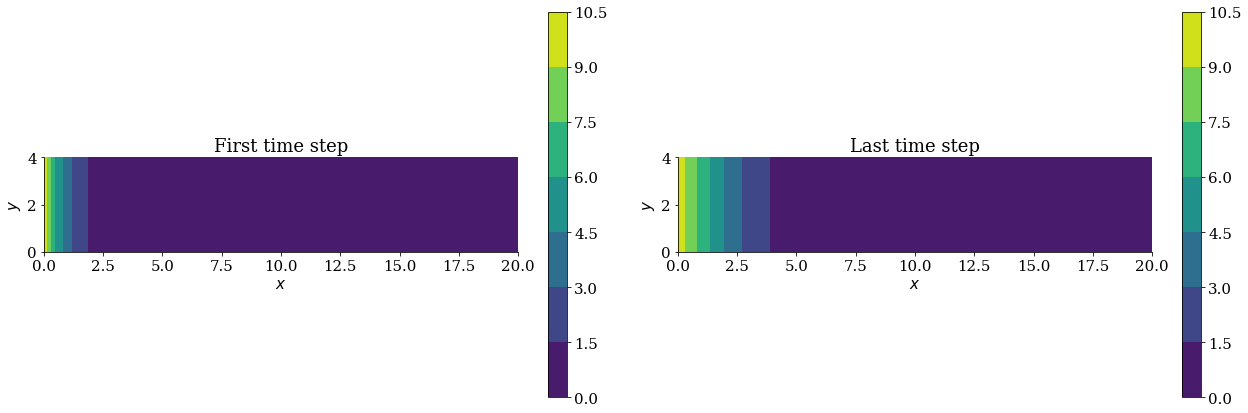

In [143]:
tsteps = [1,-1]
#TODO: calculate locally. below only estimates
print("Ne_x %.1e, Ne_y %.1e" %((dx/elx)**2/(2*ts*lambda_eff[0][0]/Cvol),(dy/ely)**2/(2*ts*lambda_eff[1][1]/Cvol)))
print("Pe_x %.1e" %(k[0][0]/mu * (pin-pout)/dx * (dx/elx)/(lambda_eff[0][0]/Cvol)))

fig, ax = plt.subplots(ncols=len(tsteps),figsize=(18,6))
for i in range(len(tsteps)):
    tcf = ax[i].tricontourf(node_list[:, 0], node_list[:, 1], sols[tsteps[i]])
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_aspect('equal')
    fig.colorbar(tcf,ax=ax[i])
ax[0].set_title('First time step')
ax[1].set_title('Last time step')
fig.tight_layout()
#fig.savefig('pressures_and_fluxes.pdf')
#fig.savefig('pressures_and_fluxes.png')

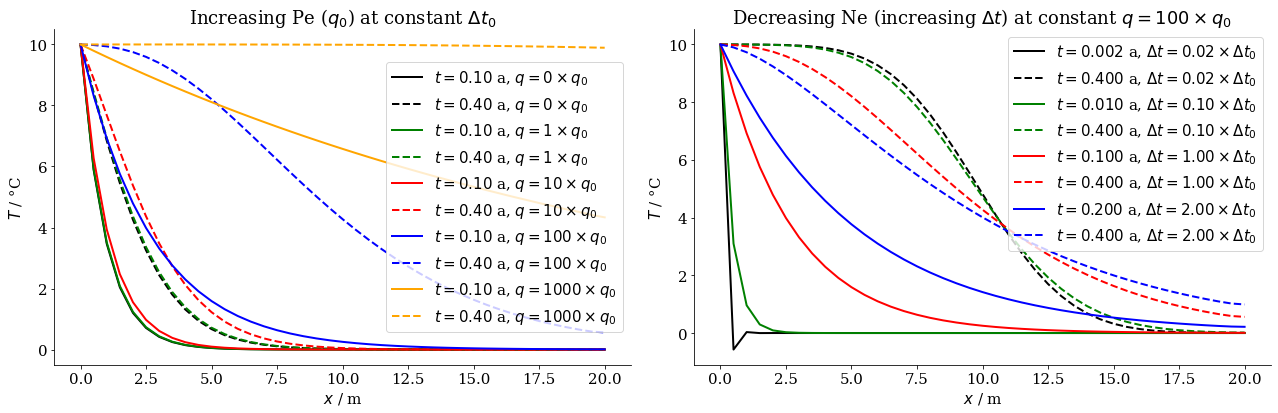

In [144]:
colors = ['black','green','red','blue','orange']
lstyles = ['-','--','.-',':']

fig, ax = plt.subplots(ncols=2,figsize=(18,6))
x_nodes = np.where(node_list.T[1]==0)
x_line = node_list[x_nodes]


for f, fac in enumerate([0,1,10,100,1000]): #factors on flow rate
    times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p*fac)
    for t, tval in enumerate([1,-1]):
        ax[0].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $q = %i \\times q_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])

for f, fac in enumerate([0.02,0.1,1,2]): #factors on flow rate
    times, sols = time_loop(ts*fac,node_list,element_vector,solution_p*0,solution_p*100)
    for t, tval in enumerate([1,-1]):
        ax[1].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.3f$ a, $\\Delta t = %.2f \\times \\Delta t_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])


for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('$x$ / m')
    ax[i].set_ylabel('$T$ / °C')
ax[0].set_title('Increasing Pe ($q_0$) at constant $\\Delta t_0$')
ax[1].set_title('Decreasing Ne (increasing $\Delta t$) at constant $q = 100\\times q_0$')
fig.tight_layout();

We observe that advection is stable and that the instabilities are gradient (diffusion) driven. However, larger time steps flatten the advection front (numerical diffusion). This is related to the representation of the diffusive gradient / front that enters the material and smoothens with time. For a large $\Delta t$, already the inital front will be more diffuse.

Let's repeat this set of simulations on a finer grid.

In [145]:
dx = 20
dy = 4
elx = 60
ely = 1
connectivity, element_vector, node_list, solution = generate_discrete_domain(dx=dx,dy=dy,nelx=elx,nely=ely)

In [146]:
Kp, fp = global_assembler(node_list,element_vector)
left = np.where(node_list.T[0]==0)
right = np.where(node_list.T[0]==dx)

pin = 1 #flow problem is linear. solution to be scaled.
pout = 0
for i in left:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, pin)
for i in right:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, 0)

solution_p = np.linalg.solve(Kp,fp)

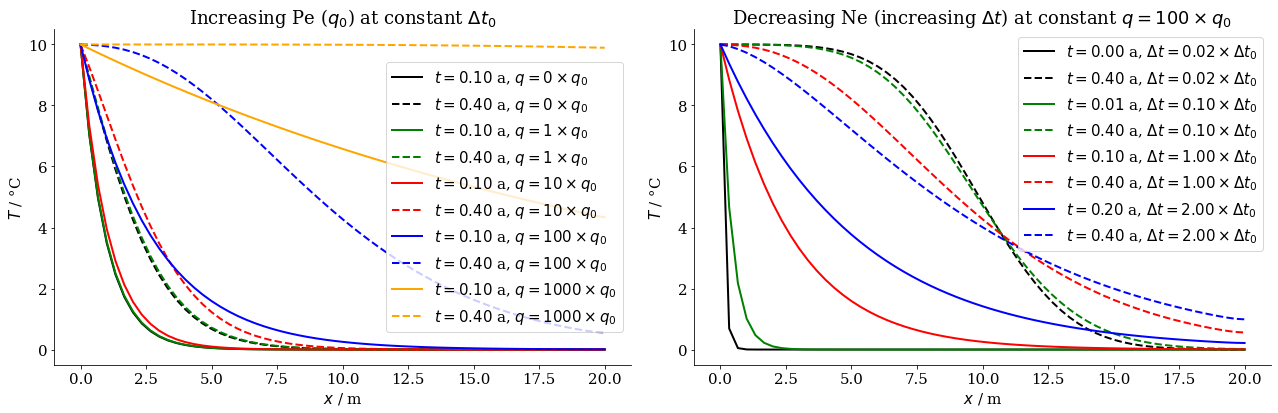

In [147]:
colors = ['black','green','red','blue','orange']
lstyles = ['-','--','.-',':']

fig, ax = plt.subplots(ncols=2,figsize=(18,6))
x_nodes = np.where(node_list.T[1]==0)
x_line = node_list[x_nodes]


for f, fac in enumerate([0,1,10,100,1000]): #factors on flow rate
    times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p*fac)
    for t, tval in enumerate([1,-1]):
        ax[0].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $q = %i \\times q_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])

for f, fac in enumerate([0.02,0.1,1,2]): #factors on flow rate
    times, sols = time_loop(ts*fac,node_list,element_vector,solution_p*0,solution_p*100)
    for t, tval in enumerate([1,-1]):
        ax[1].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $\\Delta t = %.2f \\times \\Delta t_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])


for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('$x$ / m')
    ax[i].set_ylabel('$T$ / °C')
ax[0].set_title('Increasing Pe ($q_0$) at constant $\\Delta t_0$')
ax[1].set_title('Decreasing Ne (increasing $\Delta t$) at constant $q = 100\\times q_0$')
fig.tight_layout();

Let's use only 10 fine initial time steps and then coarse ones.

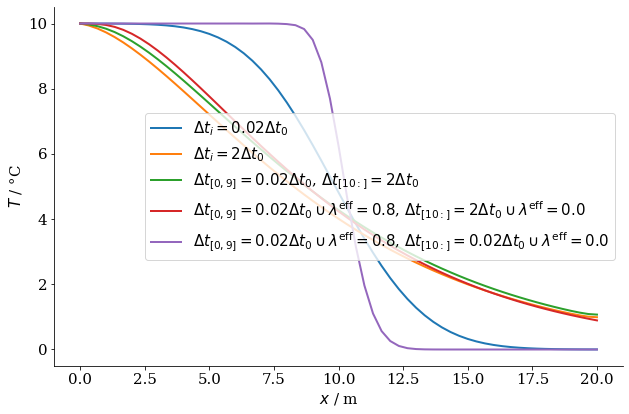

In [148]:
colors = ['black','green','red','blue','yellow']
lstyles = ['-','--','.-',':']

fig, ax = plt.subplots(figsize=(9,6))
x_nodes = np.where(node_list.T[1]==0)
x_line = node_list[x_nodes]

times_fine, sols_fine = time_loop(ts*0.02,node_list,element_vector,solution_p*0,solution_p*100)
times_coarse, sols_coarse = time_loop(ts*2,node_list,element_vector,solution_p*0,solution_p*100)
times_variable, sols_variable = time_loop(ts*2,node_list,element_vector,sols_fine[10],solution_p*100)

lambda_eff = np.diag([0.,0.])
times_adv, sols_adv = time_loop(ts*2,node_list,element_vector,sols_fine[10],solution_p*100)
times_adv_f, sols_adv_f = time_loop(ts*0.02,node_list,element_vector,sols_fine[10],solution_p*100)
lambda_eff = np.diag([0.8,0.8])

ax.plot(x_line.T[0],sols_fine[-1][x_nodes],label='$\\Delta t_i = 0.02 \\Delta t_0$')
ax.plot(x_line.T[0],sols_coarse[-1][x_nodes],label='$\\Delta t_i = 2 \\Delta t_0$')
ax.plot(x_line.T[0],sols_variable[-1][x_nodes],label='$\\Delta t_{[0,9]} = 0.02 \\Delta t_0$, $\\Delta t_{[10:]} = 2 \\Delta t_0$')
ax.plot(x_line.T[0],sols_adv[-1][x_nodes],
        label='$\\Delta t_{[0,9]} = 0.02 \\Delta t_0 \cup \\lambda^\mathrm{eff}=0.8$, $\\Delta t_{[10:]} = 2 \\Delta t_0 \cup \\lambda^\mathrm{eff}=0.0$')
ax.plot(x_line.T[0],sols_adv_f[-1][x_nodes],
        label='$\\Delta t_{[0,9]} = 0.02 \\Delta t_0 \cup \\lambda^\mathrm{eff}=0.8$, $\\Delta t_{[10:]} = 0.02 \\Delta t_0 \cup \\lambda^\mathrm{eff}=0.0$')

ax.legend()
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$T$ / °C')
fig.tight_layout();

## Observations

The diffusion-induced stability problems vanish as expected. The time step impact on numerical diffusion stays. Thus, we arrive at the intermediate conclusion that

* $\Delta t$ needs to be small enough to resolve non-linearities and avoid early diffusive flattening of gradients, so that the advected fronts smoothen physically as they are propagated through the domain based on a valid initial profile.
* With the finer time resolution comes the previously observed need for finer spatial resolution and thus computational cost. 
* CFL criteria are not relevant here in the implicit FE scheme but may, in the presence of non-linearities and path-dependencies, become useful indicators nevertheless.
* Furthermore, while large time steps are stable, they are not accurate. Large time steps in advection lead to numerical diffusion.
* Computational time can be saved with coarser time steps and the consequent possibility to use coarser meshes. However, the problems will be overly diffusive.

Note, that instabilities can not only be triggered on domain boundaries. Material property contrasts, notably diffusive ones (permeability, heat conductivity, etc.), can induce sharp gradients in the associated variables and thus spawn oscillations at material interfaces. Likewise, transport diversion in anisotropic meshes can trigger instabilities. Thus, the stability criterion evaluation for the determination of time step sizes and mesh resolution needs to take into account:

* The dominant material groups (e.g. low diffusivities)
* Mesh anisotropy (e.g. mesh coarse horizontally, fine vertically)
* Property anisotropy (e.g. high diffusivity horizontally, low diffusivity vertically)
* Potential transient effects, boundary phenomena, sources etc.

These effects interact.

Let's try with **counterflow**, i.e. advection in the opposite direction of conduction, creating a steep temperature front.

In [149]:
Kp, fp = global_assembler(node_list,element_vector)
inlet = np.where(node_list.T[0]==0)
outlet = np.where(node_list.T[0]==dx)

pin = 1 #flow problem is linear. solution to be scaled.
pout = 0
for i in inlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, 0)
for i in outlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, pin)

solution_p_inv = np.linalg.solve(Kp,fp)

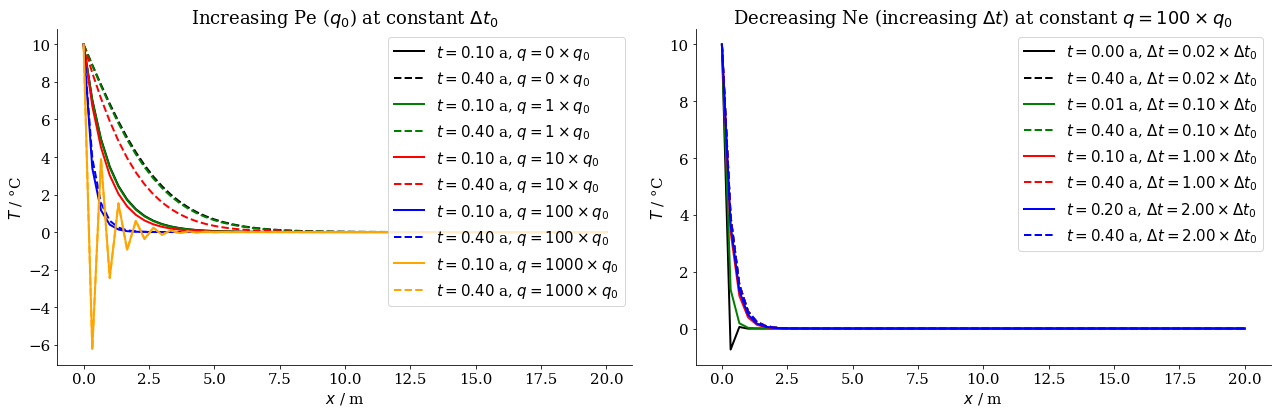

In [150]:
colors = ['black','green','red','blue','orange']
lstyles = ['-','--','.-',':']

fig, ax = plt.subplots(ncols=2,figsize=(18,6))
x_nodes = np.where(node_list.T[1]==0)
x_line = node_list[x_nodes]


for f, fac in enumerate([0,1,10,100,1000]): #factors on flow rate
    times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p_inv*fac)
    for t, tval in enumerate([1,-1]):
        ax[0].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $q = %i \\times q_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])

for f, fac in enumerate([0.02,0.1,1,2]): #factors on time step
    times, sols = time_loop(ts*fac,node_list,element_vector,solution_p*0,solution_p_inv*100)
    for t, tval in enumerate([1,-1]):
        ax[1].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $\\Delta t = %.2f \\times \\Delta t_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])


for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('$x$ / m')
    ax[i].set_ylabel('$T$ / °C')
ax[0].set_title('Increasing Pe ($q_0$) at constant $\\Delta t_0$')
ax[1].set_title('Decreasing Ne (increasing $\Delta t$) at constant $q = 100\\times q_0$')
fig.tight_layout();

We observe the steeper gradients up to the point where oscillations occur. How does this behave in combination with a conductive Neumann-bc? First in parallel flow, then in counter-flow.

In [151]:
times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p*0)

In [152]:
KT, fT = global_assembler(node_list,element_vector,'T',1e2,sols[-1],solution_p*0)
fluxes_T = KT.dot(sols[-1])-fT
influx = fluxes_T[0:3]

In [153]:
def time_loop_N(dt,nodes,elements,solution1,solution2,tendfac=1):
    #Startwerte
    t_end = .4*365*60*60*24*tendfac #s
    absolute_tolerance = 1.e-6
    max_iter = 20
    y = [solution1] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = y[-1] #Starting value for recursive update
        i = 0
        #
        while True:
            KT, fT = global_assembler(nodes,elements,'T',dt,y[-1],solution2)
            left = np.where(node_list.T[0]==0)
            for bc in inlet:
                fT[bc] += influx[bc]
            solution = np.linalg.solve(KT,fT)
            i += 1
            if (np.abs(np.linalg.norm(solution) - np.linalg.norm(y_old)) < absolute_tolerance or i > max_iter): #if change is below tolerance, stop iterations
                break
            y_old = solution #preparation of next recursion

        #print(solution)
        y.append(solution) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

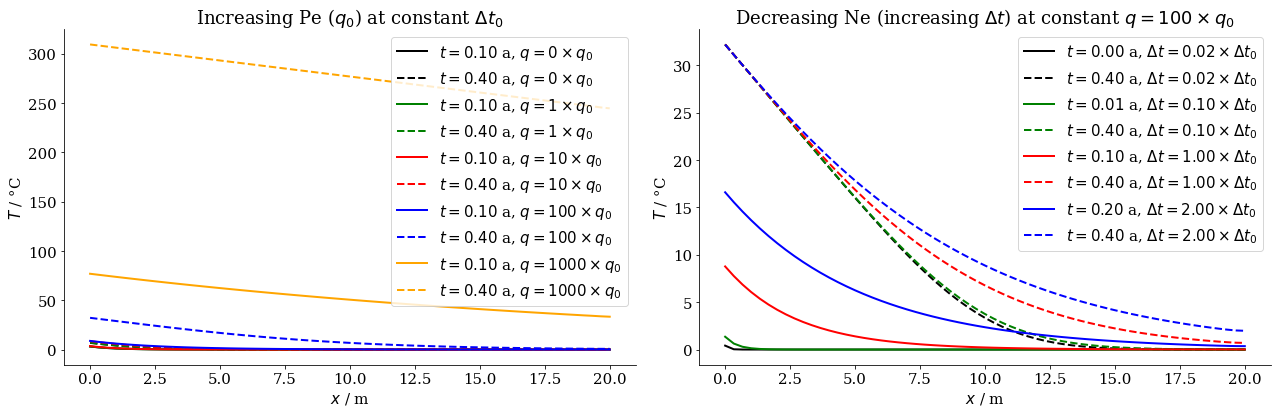

In [154]:
colors = ['black','green','red','blue','orange']
lstyles = ['-','--','.-',':']

fig, ax = plt.subplots(ncols=2,figsize=(18,6))
x_nodes = np.where(node_list.T[1]==0)
x_line = node_list[x_nodes]


for f, fac in enumerate([0,1,10,100,1000]): #factors on flow rate
    times, sols = time_loop_N(ts,node_list,element_vector,solution_p*0,solution_p*fac)
    for t, tval in enumerate([1,-1]):
        ax[0].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $q = %i \\times q_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])

for f, fac in enumerate([0.02,0.1,1,2]): #factors on time step
    times, sols = time_loop_N(ts*fac,node_list,element_vector,solution_p*0,solution_p*100)
    for t, tval in enumerate([1,-1]):
        ax[1].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $\\Delta t = %.2f \\times \\Delta t_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])


for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('$x$ / m')
    ax[i].set_ylabel('$T$ / °C')
ax[0].set_title('Increasing Pe ($q_0$) at constant $\\Delta t_0$')
ax[1].set_title('Decreasing Ne (increasing $\Delta t$) at constant $q = 100\\times q_0$')
fig.tight_layout();

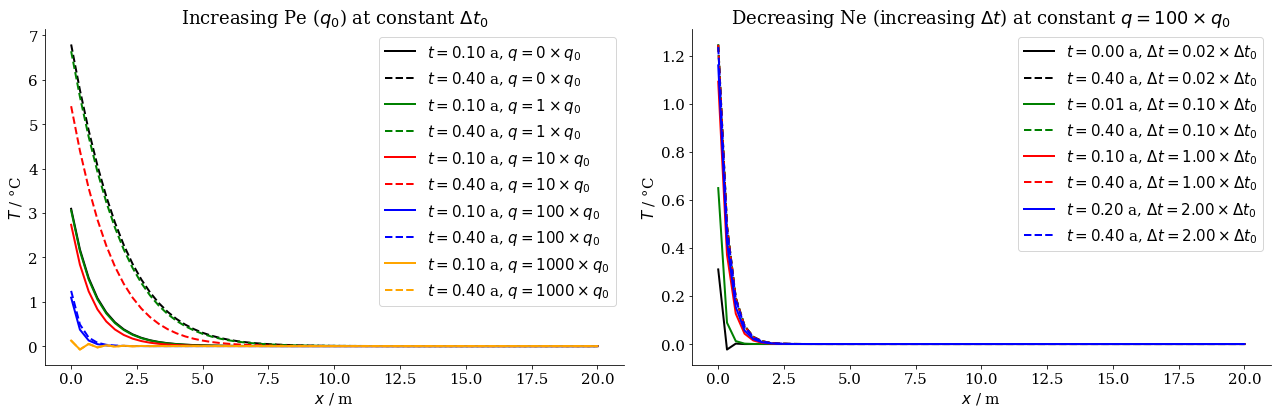

In [155]:
colors = ['black','green','red','blue','orange']
lstyles = ['-','--','.-',':']

fig, ax = plt.subplots(ncols=2,figsize=(18,6))
x_nodes = np.where(node_list.T[1]==0)
x_line = node_list[x_nodes]


for f, fac in enumerate([0,1,10,100,1000]): #factors on flow rate
    times, sols = time_loop_N(ts,node_list,element_vector,solution_p*0,solution_p_inv*fac)
    for t, tval in enumerate([1,-1]):
        ax[0].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $q = %i \\times q_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])

for f, fac in enumerate([0.02,0.1,1,2]): #factors on time step
    times, sols = time_loop_N(ts*fac,node_list,element_vector,solution_p*0,solution_p_inv*100)
    for t, tval in enumerate([1,-1]):
        ax[1].plot(x_line.T[0],sols[tval][x_nodes],label="$t = %.2f$ a, $\\Delta t = %.2f \\times \\Delta t_0$"
                   %(times[tval]/(365*60*60*24),fac),color=colors[f],ls=lstyles[t])


for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('$x$ / m')
    ax[i].set_ylabel('$T$ / °C')
ax[0].set_title('Increasing Pe ($q_0$) at constant $\\Delta t_0$')
ax[1].set_title('Decreasing Ne (increasing $\Delta t$) at constant $q = 100\\times q_0$')
fig.tight_layout();

We see that thermal Neumann bc on inlets and outlets require special consideration and may require switching between different (conductive, total) flux formulations depending on the problem considered. This switch may even have to occur dynamically during the simulation.

### 2D problem, anisotropic mesh

Let's look at an infiltration-exfiltration problem with a different spatial resolution in the two directions

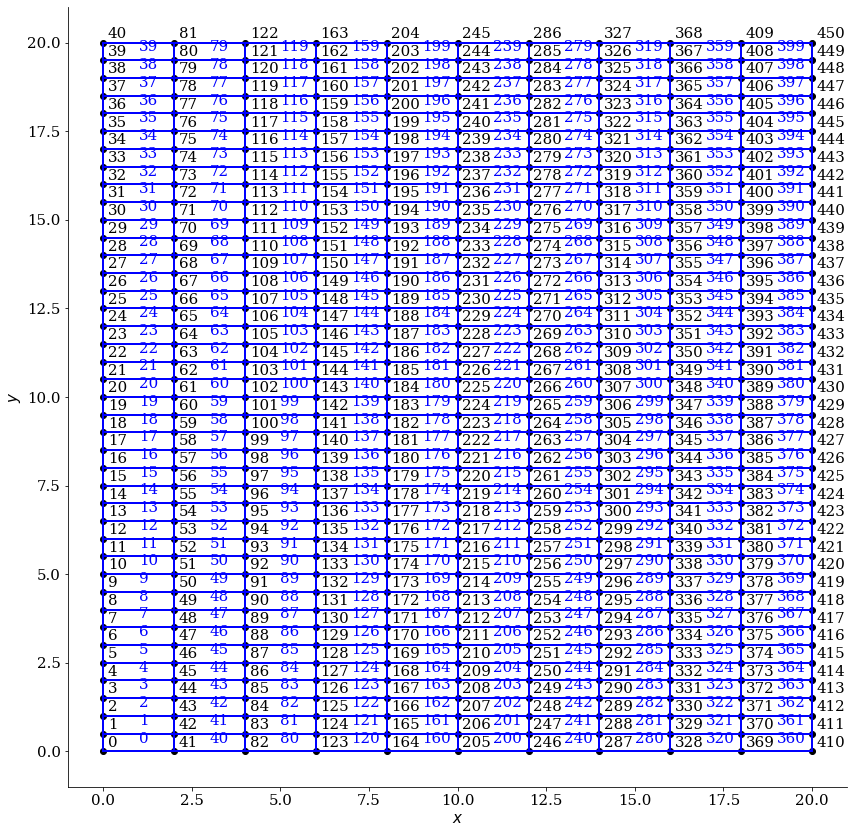

In [156]:
dx = 20
dy = 20
elx = 10
ely = 40
connectivity, element_vector, node_list, solution = generate_discrete_domain(dx=dx,dy=dy,nelx=elx,nely=ely)
plot_mesh(node_list,element_vector)

In [157]:
Kp, fp = global_assembler(node_list,element_vector)
inlet = np.intersect1d(np.where(node_list.T[1]==20),np.where(node_list.T[0]>15))
outlet = np.intersect1d(np.where(node_list.T[1]==20),np.where(node_list.T[0]<5))

pin = 1 #flow problem is linear. solution to be scaled.
pout = 0
for i in inlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, pin)
for i in outlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, 0)

solution_p = np.linalg.solve(Kp,fp)

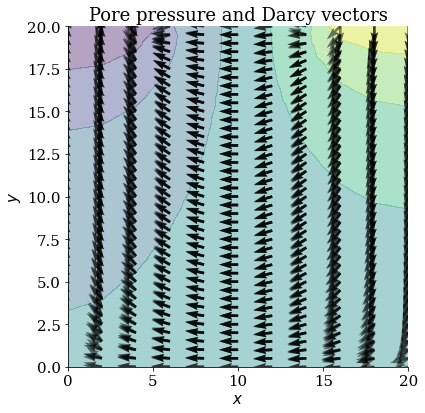

In [158]:
fig, ax = plt.subplots()
ax.tricontourf(node_list[:, 0], node_list[:, 1], solution_p,alpha=0.4)
for i,elem in enumerate(element_vector):
    local_p = np.take(solution_p,elem._quad4_element__global_ids)
    local_coord = elem._quad4_element__natural_coords
    X, Y = np.meshgrid(elem._quad4_element__coords.T[0],elem._quad4_element__coords.T[1])
    for i in range(4):
        dN_dX = grad_shape_function(local_coord[i][0],local_coord[i][1],elem)
        q = np.dot(-k/mu,dN_dX.dot(local_p))
        ax.quiver(elem._quad4_element__coords[i][0],elem._quad4_element__coords[i][1],q[0],q[1],alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Pore pressure and Darcy vectors')
fig.tight_layout()

In [159]:
ts = .05*365*60*60*24
times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p,tendfac=10)

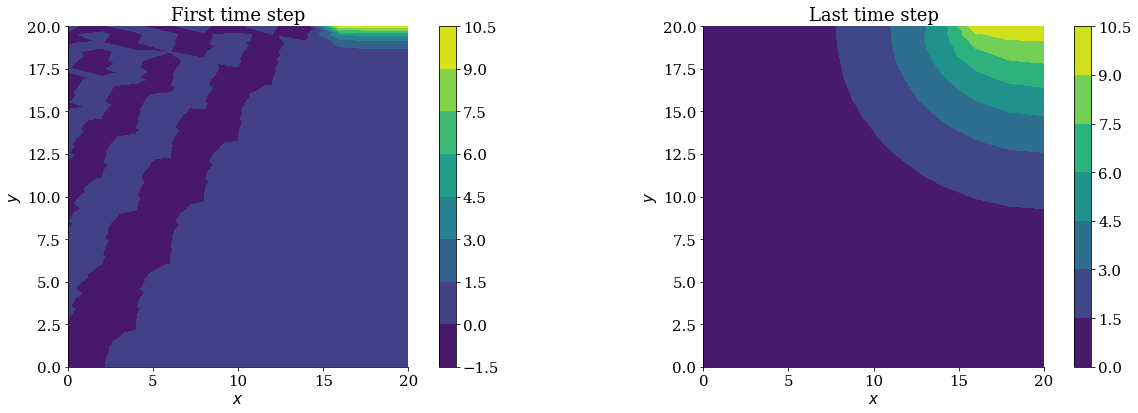

In [160]:
tsteps = [1,-1]
#TODO: calculate locally. below only estimates

fig, ax = plt.subplots(ncols=len(tsteps),figsize=(18,6))
for i in range(len(tsteps)):
    tcf = ax[i].tricontourf(node_list[:, 0], node_list[:, 1], sols[tsteps[i]])
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_aspect('equal')
    fig.colorbar(tcf,ax=ax[i])
ax[0].set_title('First time step')
ax[1].set_title('Last time step')
fig.tight_layout()

The above solution is the case with pure heat conduction. The horizontal resolution is too coarse in this case and sparks horizontally propagating oszillations that then diffuse out in diffusion dominated cases. In a moving bc case we will continuously spark such oscillations. In cases with advection, these oscillations are propagated along the flow direction:

In [161]:
times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p*30,tendfac=10)

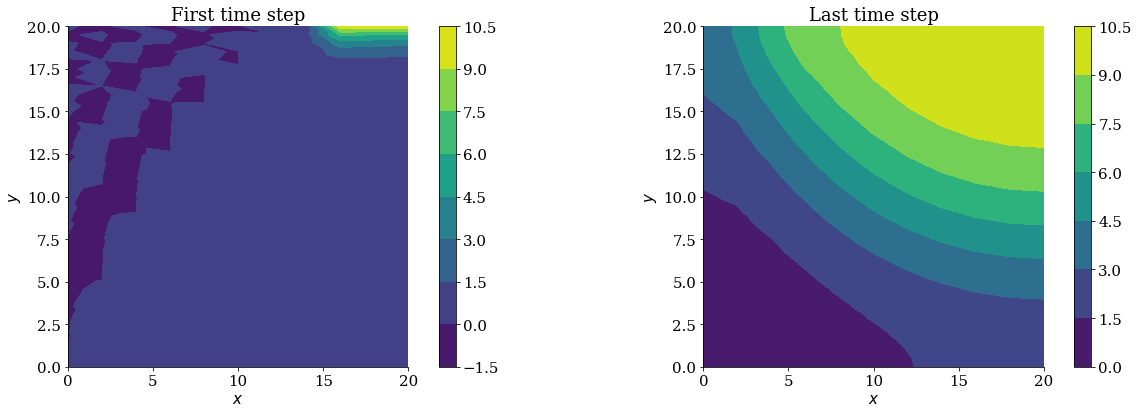

In [162]:
tsteps = [1,-1]
#TODO: calculate locally. below only estimates

fig, ax = plt.subplots(ncols=len(tsteps),figsize=(18,6))
for i in range(len(tsteps)):
    tcf = ax[i].tricontourf(node_list[:, 0], node_list[:, 1], sols[tsteps[i]])
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_aspect('equal')
    fig.colorbar(tcf,ax=ax[i])
ax[0].set_title('First time step')
ax[1].set_title('Last time step')
fig.tight_layout()

The situation is improved with an increased horizontal resolution:

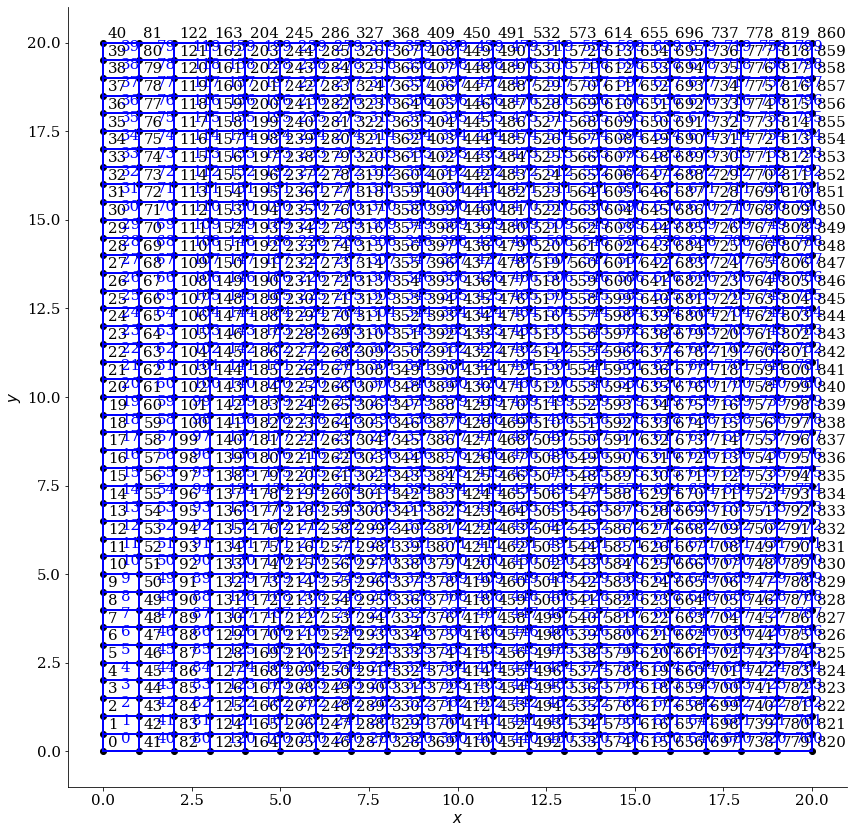

In [163]:
dx = 20
dy = 20
elx = 20
ely = 40
connectivity, element_vector, node_list, solution = generate_discrete_domain(dx=dx,dy=dy,nelx=elx,nely=ely)
plot_mesh(node_list,element_vector)

In [164]:
Kp, fp = global_assembler(node_list,element_vector)
inlet = np.intersect1d(np.where(node_list.T[1]==20),np.where(node_list.T[0]>15))
outlet = np.intersect1d(np.where(node_list.T[1]==20),np.where(node_list.T[0]<5))

pin = 1 #flow problem is linear. solution to be scaled.
pout = 0
for i in inlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, pin)
for i in outlet:
    Kp, fp = apply_Dirichlet_bc(Kp, fp, i, 0)

solution_p = np.linalg.solve(Kp,fp)

In [165]:
times, sols = time_loop(ts,node_list,element_vector,solution_p*0,solution_p*30,tendfac=10)

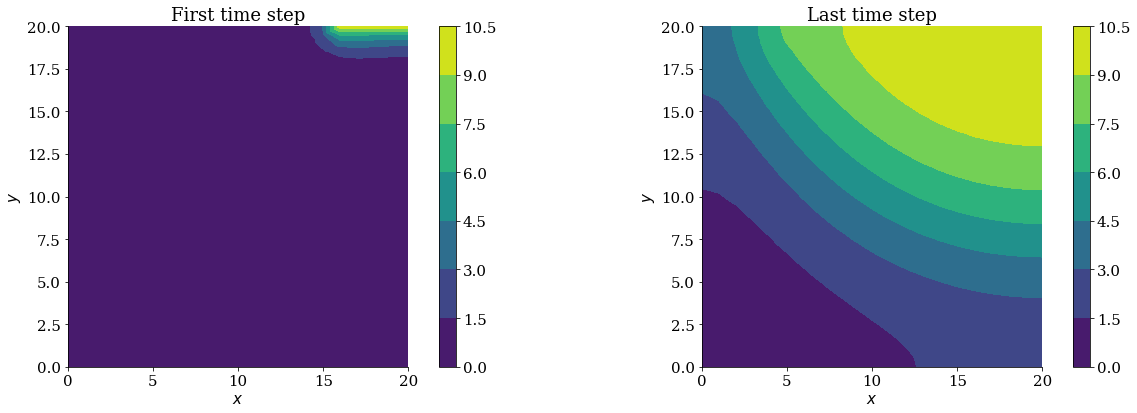

In [166]:
tsteps = [1,-1]
#TODO: calculate locally. below only estimates

fig, ax = plt.subplots(ncols=len(tsteps),figsize=(18,6))
for i in range(len(tsteps)):
    tcf = ax[i].tricontourf(node_list[:, 0], node_list[:, 1], sols[tsteps[i]])
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_aspect('equal')
    fig.colorbar(tcf,ax=ax[i])
ax[0].set_title('First time step')
ax[1].set_title('Last time step')
fig.tight_layout()